In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from tqdm.notebook import tqdm

In [2]:
data = np.load('mednist.npz')

In [3]:
pixels = data['px']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(data['label'])
labels

array([2, 2, 5, ..., 2, 5, 1])

In [4]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

def get_key(val):
    for key, value in le_name_mapping.items():
        if val == value:
            return key
 
    return "Key doesn't exist!"

{'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


In [5]:
m, n = pixels.shape
split = 0.8
idx = round(split * n)

Y_dev = labels[0:idx]
X_dev = pixels[0:idx].T
X_dev = X_dev / 255.

Y_train = labels[idx:]
X_train = pixels[idx:].T
X_train = X_train / 255.
_,m_train = X_train.shape

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)

(4096, 55677)
(55677,)
(4096, 3277)
(3277,)


 Label:  Hand


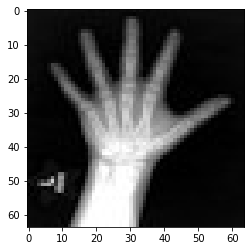

 Label:  AbdomenCT


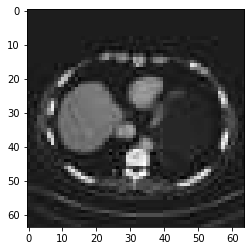

 Label:  HeadCT


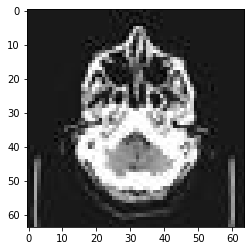

 Label:  ChestCT


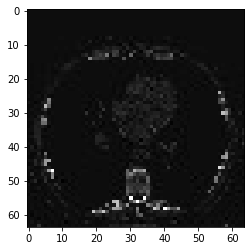

In [7]:
def plot(index, X, Y):
    current_image = X[:, index, None]
    label = Y[index]
    
    print(" Label: ", get_key(label))
    
    current_image = current_image.reshape((64, 64)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
plot(2, X_train, Y_train)
plot(200, X_train, Y_train)
plot(2, X_dev, Y_dev)
plot(200, X_dev, Y_dev)

In [8]:
def init_params():
    W1 = np.random.rand(6, 4096) - 0.5
    b1 = np.random.rand(6, 1) - 0.5
    W2 = np.random.rand(6, 6) - 0.5
    b2 = np.random.rand(6, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2) 
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [9]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    print("[INFO]: Starting training!\n")
    for i in tqdm(range(iterations)):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 40 == 0:
            predictions = get_predictions(A2)
            print("Iteration: ", i, " Accuracy : " ,get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [10]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

[INFO]: Starting training!



  0%|          | 0/500 [00:00<?, ?it/s]

Iteration:  0  Accuracy :  0.16295777430536845
Iteration:  40  Accuracy :  0.5465632128167826
Iteration:  80  Accuracy :  0.6714442229286779
Iteration:  120  Accuracy :  0.7428022343157857
Iteration:  160  Accuracy :  0.7464841855703432
Iteration:  200  Accuracy :  0.9177398207518365
Iteration:  240  Accuracy :  0.9077536505199634
Iteration:  280  Accuracy :  0.934658835784974
Iteration:  320  Accuracy :  0.9408014081218457
Iteration:  360  Accuracy :  0.9368680065377085
Iteration:  400  Accuracy :  0.8591878154354581
Iteration:  440  Accuracy :  0.9119205416958529
Iteration:  480  Accuracy :  0.8396824541552167


In [11]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_dev[:, index, None]
    prediction = make_predictions(X_dev[:, index, None], W1, b1, W2, b2)
    label = Y_dev[index]
    
    print("Prediction: ", get_key(prediction)," Label: ", get_key(label))
    
    current_image = current_image.reshape((64, 64)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  CXR  Label:  CXR


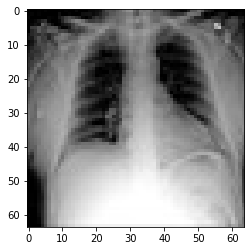

Prediction:  HeadCT  Label:  HeadCT


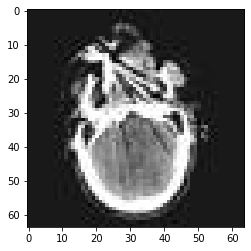

Prediction:  Hand  Label:  Hand


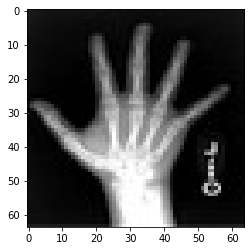

Prediction:  AbdomenCT  Label:  AbdomenCT


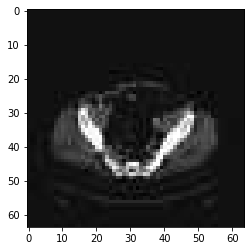

In [12]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(20, W1, b1, W2, b2)
test_prediction(30, W1, b1, W2, b2)
test_prediction(60, W1, b1, W2, b2)

In [13]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

0.9307293256026854